## mimlsvm

mi = mulit-instance
ml = multi-label
svm = svm

As described in Shen et al 2009: http://ieeexplore.ieee.org/document/5346261/

good params: {'svm_degree': 3, 'svm_kernel': 'poly', 'medoid_normalization': None, 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto', 'vectorizer_norm': None, 'svm_c': 1}

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import nltk
import os
import re
import pickle
import sklearn
import sys
import string

from nltk import TextTilingTokenizer

from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, GridSearchCV,ParameterGrid, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler,MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.svm import SVC

from tqdm import *

%matplotlib inline
%load_ext autoreload
%autoreload 1

In [2]:
src_dir = os.path.join(os.getcwd(), os.pardir, '../../')
sys.path.append(src_dir)

In [3]:
%aimport src.data.movielens_20m_imdb
%aimport src.helpers.labels, src.helpers.segments
%aimport src.utils.dataframes, src.utils.clusters, src.utils.metrics, src.utils.distances, src.utils.plotting

In [4]:
from src.data.movielens_20m_imdb import load_df_or_get_from_cache
from src.helpers.labels import truncate_labels
from src.helpers.segments import make_distance_matrix_for_segments,vectorize_segments

from src.utils.dataframes import sample_rows
from src.utils.metrics import ranking
from src.utils.clusters import k_medoids
from src.utils.distances import hausdorff
from src.utils.plotting import plot_micro_f1_at_k

In [7]:
MODELS_ROOT = os.path.abspath("../../../models/ranking/movielens-mimlsvm/")
INTERIM_DATA_ROOT = os.path.abspath("../../../data/interim/movielens-ml20m-imdb/")
PATH_TO_PROCESSED_FILE = os.path.abspath('../../../data/processed/movielens-20m-imdb-tags-and-synopses-2017-12-20.csv')

# CONFIGS

SEED= 42
W=20 # Pseudosentence size (in words) - not specified in the paper, taken from TextTiling default values
K=10 # Size (in sentences) of the block used in the block comparison method - not specified in the paper, taken from TextTiling default values
MAX_NB_WORDS=500

In [6]:
docs_df = load_df_or_get_from_cache(PATH_TO_PROCESSED_FILE,INTERIM_DATA_ROOT)

In [7]:
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [8]:
# remove this for production
# docs_df = sample_rows(docs_df,NB_DOCS)

In [9]:
docs_df['sentences'] = docs_df['synopsis'].map(lambda row: sentence_tokenizer.tokenize(row))

In [10]:
%%time
docs_df['num_sentences'] = docs_df['sentences'].map( lambda sents: len(sents))

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.62 ms


In [11]:
docs_df.head()

,movie_id,title,synopsis,tags,num_tags,sentences,num_sentences
0,1,Toy Story (1995),A boy called Andy Davis (voice: John Morris) u...,"buy,want-to-see-again,unlikely-friendships,inn...",59,[A boy called Andy Davis (voice: John Morris) ...,267
1,2,Jumanji (1995),The film begins in 1869 in the town of Brantfo...,"childish,robin-williams,time,not-for-kids,adap...",19,[The film begins in 1869 in the town of Brantf...,115
2,6,Heat (1995),An inbound Blue Line train pulls in to Firesto...,"rviolence,soundtrack,suspense,dialogue,bibliot...",57,[An inbound Blue Line train pulls in to Firest...,226
3,7,Sabrina (1995),"Sabrina Fairchild (Julia Ormond), is the Larra...","based-on-a-play,clv,remake,relationships,chick...",13,"[Sabrina Fairchild (Julia Ormond), is the Larr...",27
4,8,Tom and Huck (1995),The film opens with Injun Joe (Eric Schweig) a...,"based-on-a-book,adapted-frombook,seen",3,[The film opens with Injun Joe (Eric Schweig) ...,23


In [12]:
docs_df.iloc[0]['sentences'][:5]

['A boy called Andy Davis (voice: John Morris) uses his toys to act out a bank robbery.',
 'The bank is a cardboard box, the robber is Mr.',
 'Potato Head (voice: Don Rickles) assisted by Slinky Dog (voice: Jim Varney), and the bystanders include Bo Peep (voice: Annie Potts) and her sheep.',
 'The day is saved by cowboy doll Woody (voice: Tom Hanks) playing the sheriff, with help from Rex the dinosaur (voice: Wallace Shawn).',
 'Woody is the only toy who gets to say his own lines because he has a pull-string that makes him say things like "Reach for the sky!"']

In [13]:
docs_df.describe()

,movie_id,num_tags,num_sentences
count,6710.000000,6710.000000,6710.000000
mean,41263.124888,12.214605,58.771088
std,39409.134389,14.369509,74.754297
min,1.000000,1.000000,1.000000
25%,4106.250000,3.000000,13.000000
50%,31251.000000,7.000000,37.000000
75%,74531.500000,16.000000,72.000000
max,131082.000000,189.000000,1472.000000


In [16]:
tok = TextTilingTokenizer(w=W, k=K)

In [17]:
def extract_segments(candidates):
    
    try:
        # we must manually insert "\n\n" because this is how 
        # texttilingtokenizer requires candidate boundaries to be 
        # represented.
        segments = tok.tokenize("\n\n".join(candidates))
    except ValueError:
        # this happens when the candidate list is too small for the 
        # text tiling tokenizer to be able to find segments. so just return
        # the original sentences.
        segments= candidates
        
    # now remove the artificially added chars
    segments = [segment.replace("\n\n"," ").strip() for segment in segments]
    
    return segments

In [8]:
%%time
if os.path.isfile(INTERIM_DATA_ROOT+"/docs_df_with_segments-{}.p".format(MAX_NB_WORDS)):
    print('cache hit')
    docs_df = pickle.load(open(INTERIM_DATA_ROOT+"/docs_df_with_segments-{}.p".format(MAX_NB_WORDS),"rb"))
else:
    docs_df['segments'] = docs_df['sentences'].map(lambda candidates: extract_segments(candidates))
    pickle.dump(docs_df,open(INTERIM_DATA_ROOT+"/docs_df_with_segments-{}.p".format(MAX_NB_WORDS),"wb"))

cache hit
CPU times: user 208 ms, sys: 96 ms, total: 304 ms
Wall time: 305 ms


In [9]:
docs_df['segments'][0][:5]

['A boy called Andy Davis (voice: John Morris) uses his toys to act out a bank robbery. The bank is a cardboard box, the robber is Mr. Potato Head (voice: Don Rickles) assisted by Slinky Dog (voice: Jim Varney), and the bystanders include Bo Peep (voice: Annie Potts) and her sheep. The day is saved by cowboy doll Woody (voice: Tom Hanks) playing the sheriff, with help from Rex the dinosaur (voice: Wallace Shawn). Woody is the only toy who gets to say his own lines because he has a pull-string that makes him say things like "Reach for the sky!"',
 'and "You\'re my favorite deputy!" During the opening credits (soundtrack: Randy Newman\'s "You\'ve Got a Friend in Me"), Andy takes Woody downstairs to find his mother (voice: Laurie Metcalf) decorating the dining room for his birthday party. He asks if they can leave the decorations up until they move, and his mom agrees. She says the guests will arrive soon and sends him back upstairs to get his baby sister Molly (voice: Hannah Unkrich), wh

In [10]:
segments = docs_df['segments'].values
documents = docs_df['synopsis'].values
labels = docs_df["tags"].map(lambda tagstring: tagstring.split(","))

In [11]:
def make_train_dataset(distance_matrix, medoid_indices):
    """
    Returns a matrix where element Aij contains the distance from sample i to medoid j.

    :param distance_matrix: MxM matrix with pairwise distances
    :param medoid_indices: array of length N containing the indices of the medoids for each cluster
    :return: distances to medoids (MxN matrix)
    """

    return distance_matrix[:,medoid_indices]

In [12]:
def make_test_dataset(source_vectorized_segments, medoid_vectorized_segments):
    """
    Calculates the distances from every source_document (reprsented by its segments) to every medoid
    document (also represented by its segments) using the hausdorff distance.
    
    Returns a matrix where element Aij contains the distance from sample i to medoid j.

    :param source_vectorized_segments: array of length M, where each element is a matrix with one row
        for every segment in a source document
    :param medoid_vectorized_segments: array of length N where each element is a matrix with one row
        for every segment in a medoid document
    :return: distances to medoids (MxN matrix)
    """
    
    num_test_samples = len(source_vectorized_segments)
    num_medoids = len(medoid_vectorized_segments)
    
    test_dataset = np.zeros((num_test_samples,num_medoids))    
    
    for i,source_segments in enumerate(source_vectorized_segments):
        for j,medoid_segments in enumerate(medoid_vectorized_segments):
            test_dataset[i][j] = hausdorff(source_segments.toarray(),medoid_segments.toarray())
            
    return np.array(test_dataset)

In [13]:
# segments, documents and labelsets are defined outside of the parameterGrid loop
# because they're the same for every configuration    
segments_train, segments_test, documents_train, documents_test, Y_train, Y_test = train_test_split(segments,
                                                                                               documents,
                                                                                               labels,
                                                                                               test_size=0.15)

print('total number of train documents: {}'.format(len(documents_train)))
print('total number of validation documents: {}'.format(len(documents_test)))

total number of train documents: 5703
total number of validation documents: 1007


In [14]:
# the binarizer needs to be fit on all labels
mlb = MultiLabelBinarizer()
mlb.fit(labels)

Y_train = mlb.transform(Y_train)
Y_test = mlb.transform(Y_test)

print("total number of unique tags: {} ".format(len(mlb.classes_)))

total number of unique tags: 2138 


In [26]:
VECTORIZER_NORM = ['l1','l2',None]
W=20 # Pseudosentence size (in words) - not specified in the paper, taken from TextTiling default values
K=10 # Size (in sentences) of the block used in the block comparison method - not specified in the paper, taken from TextTiling default values

# calculating medoids
NORMALIZATION = ['standard','minmax',None] # not specified in the paper
SAMPLE_TO_NB_MEDOIDS_RATIO = [0.2,0.3,0.4] # not specified in the paper, but taken from MIMLSVM canonical implementation
# classification
SVM_KERNEL=['rbf','linear','poly'] # not specified in the paper, but taken from MIMLSVM canonical implementation
SVM_GAMMA=['auto'] # not specified in the paper, but taken from MIMLSVM canonical implementation
SVM_C= [0.001,0.01,0.1,1]# not specified in the paper, but taken from MIMLSVM canonical implementation
SVM_DEGREE=[3,4,5]

In [27]:
grid_search_parameters = [
    {
        'medoid_normalization':  NORMALIZATION,
        'svm_kernel': ['poly'],
        'svm_c':SVM_C,
        'svm_degree' :SVM_DEGREE,
        'svm_gamma':SVM_GAMMA,
        'vectorizer_norm': VECTORIZER_NORM,
        'nb_medoids_ratio': SAMPLE_TO_NB_MEDOIDS_RATIO
    },
    {
        'medoid_normalization':  NORMALIZATION,
        'svm_kernel': ['rbf'],
        'svm_c':SVM_C,
        'svm_degree' :[None],
        'svm_gamma':SVM_GAMMA,
        'vectorizer_norm': VECTORIZER_NORM,
        'nb_medoids_ratio': SAMPLE_TO_NB_MEDOIDS_RATIO
    },
    {
        'medoid_normalization':  NORMALIZATION,
        'svm_kernel': ['linear'],
        'svm_c':SVM_C,
        'svm_gamma':SVM_GAMMA,
        'svm_degree' :[None],
        'vectorizer_norm': VECTORIZER_NORM,
        'nb_medoids_ratio': SAMPLE_TO_NB_MEDOIDS_RATIO
    }
]

In [28]:
print('total number of configurations to test: {}'.format(len(ParameterGrid(grid_search_parameters))))

total number of configurations to test: 540


In [29]:
final_parameters = [
    {
        'medoid_normalization':  [None],
        'svm_kernel': ['poly'],
        'svm_c':[1.0],
        'svm_degree' :[3],
        'svm_gamma':['auto'],
        'vectorizer_norm': [None],
        'nb_medoids_ratio': [0.2],
        'max_features':[500]
    }
]

In [32]:
for (i,configuration) in enumerate(ParameterGrid(final_parameters)):
    
    tfidf_vectorizer = CountVectorizer(
        max_features=configuration['max_features'], 
        norm=configuration['vectorizer_norm'])
    
    # TRAINING SET
    tfidf_vectorizer.fit(documents_train)
    tfidf_segments_train = vectorize_segments(segments_train, tfidf_vectorizer)
        
    # THE FOLLOWING BLOCK TAKES SOME TIME, BUT IT WILL ONLY RUN ONCE
    
    path_to_cache = MODELS_ROOT.rstrip('/') + "/distance-matrix-train-{}-{}.p".format(
        configuration['max_features'],
        configuration['vectorizer_norm'])
    
    if os.path.isfile(path_to_cache):
        print('cache hit')
        dist_matrix_train = pickle.load(open(path_to_cache,"rb"))
    else:
        print('Fitting distance matrix for norm={}'.format(configuration['vectorizer_norm']))
        
        dist_matrix_train = make_distance_matrix_for_segments(tfidf_segments_train)
        pickle.dump(dist_matrix_train, open(path_to_cache, "wb"))
    
    # nb_medoids depends upon the dataset length
    ratio = configuration['nb_medoids_ratio']
    nb_medoids = int(len(tfidf_segments_train) * ratio)
    
    medoids_indices_train = k_medoids(dist_matrix_train,nb_medoids)[0]

    X_train = make_train_dataset(dist_matrix_train,medoids_indices_train)
    
    # TEST SET
    
    tfidf_segments_test = vectorize_segments(segments_test, tfidf_vectorizer)
          
    # medoids trained on the training set
    fitted_medoids = tfidf_segments_train[medoids_indices_train]
    X_test = make_test_dataset(tfidf_segments_test,fitted_medoids)     
        
    svm = SVC(kernel=configuration['svm_kernel'],
            gamma=configuration['svm_gamma'],
            C=configuration['svm_c'],
            degree=configuration['svm_degree'])
    
    clf = OneVsRestClassifier(CalibratedClassifierCV(svm,cv=2),n_jobs=-1)        

    if configuration['medoid_normalization'] == 'standard':      
        scaler = StandardScaler()
        X_train_final = scaler.fit_transform(X_train)
        X_test_final = scaler.transform(X_test)
    elif configuration['medoid_normalization'] == 'minmax':
        scaler = MinMaxScaler()
        X_train_final = scaler.fit_transform(X_train)
        X_test_final = scaler.transform(X_test)
    else:
        X_train_final = X_train
        X_test_final = X_test
    
    # y_train was defined outside the loop    
    clf.fit(X_train,Y_train)
    
    # train score
    Y_pred_train = clf.predict_proba(X_train)
    
    # validation score
    Y_pred_test = clf.predict_proba(X_test)  
    
    print("iter: {}, configuration: {}\n".format(i,configuration))
    
    ks = [1,2,3,4,5,6,7,8,9,10]

    for k in ks:
        print("train micro-F1 @{}: {}".format(k,ranking.micro_f1_at_k(Y_train,Y_pred_train,k=k,normalize=True)))
        print("validation micro-F1 @{}: {}".format(k,ranking.micro_f1_at_k(Y_test,Y_pred_test,k=k,normalize=True)))    

cache hit
iter: 0, configuration: {'svm_c': 1.0, 'medoid_normalization': None, 'vectorizer_norm': None, 'max_features': 500, 'nb_medoids_ratio': 0.2, 'svm_gamma': 'auto', 'svm_kernel': 'poly', 'svm_degree': 3}

train micro-F1 @1: 0.3394962876692386
validation micro-F1 @1: 0.23488168273444346
train micro-F1 @2: 0.3467169154949993
validation micro-F1 @2: 0.22241835834068843
train micro-F1 @3: 0.30880245144071566
validation micro-F1 @3: 0.21453900709219859
train micro-F1 @4: 0.2773645459694167
validation micro-F1 @4: 0.20138423755302523
train micro-F1 @5: 0.28434764297102977
validation micro-F1 @5: 0.19631022747626725
train micro-F1 @6: 0.2778197191605013
validation micro-F1 @6: 0.18830584707646178
train micro-F1 @7: 0.2654355854877254
validation micro-F1 @7: 0.18394950405770966
train micro-F1 @8: 0.2505464166570804
validation micro-F1 @8: 0.17902350813743217
train micro-F1 @9: 0.23679148059086225
validation micro-F1 @9: 0.17296643483519805
train micro-F1 @10: 0.22516144090873727
validati

## save the model

In [37]:
pickle.dump(clf, open(MODELS_ROOT.rstrip('/')+"/model-tf-idf.p", "wb"))

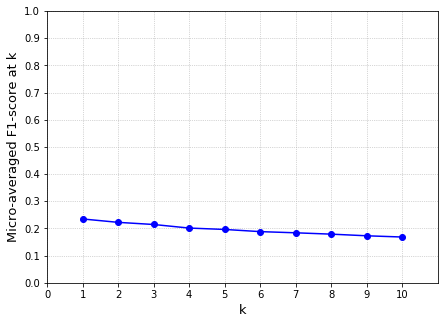

In [36]:
plt.clf()
img = plt.gcf()
ax = plt.gca()
validation_scores = [
    0.23488168273444346,0.22241835834068843,
    0.21453900709219859,0.20138423755302523,
    0.19631022747626725,0.18830584707646178,
    0.18394950405770966,0.17902350813743217,
    0.17296643483519805,0.16842488177519097
]
plot_micro_f1_at_k(validation_scores,ax)
plt.gcf().set_size_inches(7,5)
plt.gca().legend_.remove()
plt.show()